In [1]:
import numpy as np
import pandas as pd

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
# india borders
NORTH = 37.1
SOUTH = 8.07
WEST = 68.12
EAST = 97.42

STEP = 0.01

def get_idx(lat, lon):
    return (int((NORTH - lat) / STEP), int((lon - WEST) / STEP))

num_lat_steps = int((NORTH - SOUTH) / STEP)
num_lon_steps = int((EAST - WEST) / STEP)

In [ ]:
def exponential_decay(distance_squared):
    return np.exp(-6 * distance_squared)

In [ ]:
hospitals = pd.read_csv('hospital_dataset_densities.csv')
hospitals['Radius of Influence'] = hospitals['Effective Rating'] * 0.1

In [ ]:
def get_influence_map(hospitals):
    influence_map = np.zeros((num_lat_steps, num_lon_steps))
    for i in range(len(hospitals)):
        lat, lon = hospitals.loc[i, 'Latitude'], hospitals.loc[i, 'Longitude']
        idx, jdx = get_idx(lat, lon)
        r = hospitals.loc[i, 'Radius of Influence']
        r_steps = int(r / STEP)

        # Define the bounding box for influence radius
        start_i = max(0, idx - r_steps)
        end_i = min(num_lat_steps, idx + r_steps + 1)
        start_j = max(0, jdx - r_steps)
        end_j = min(num_lon_steps, jdx + r_steps + 1)

        # Generate grid of indices within the bounding box
        x_coords, y_coords = np.meshgrid(np.arange(start_i, end_i), np.arange(start_j, end_j), indexing='ij')
        distance_squared = ((x_coords - idx) ** 2 + (y_coords - jdx) ** 2) * STEP**2

        # Apply influence decay only to points within the radius
        mask = distance_squared <= r**2
        influence_map[x_coords[mask], y_coords[mask]] += exponential_decay(distance_squared[mask])

    return influence_map

influence_map = get_influence_map(hospitals)

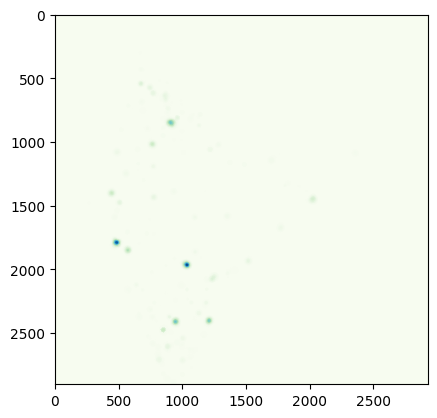

In [ ]:
# plot influence map pixel by pixel
import matplotlib.pyplot as plt
plt.imshow(influence_map, cmap='GnBu', interpolation='nearest')
plt.savefig('influences1.png')

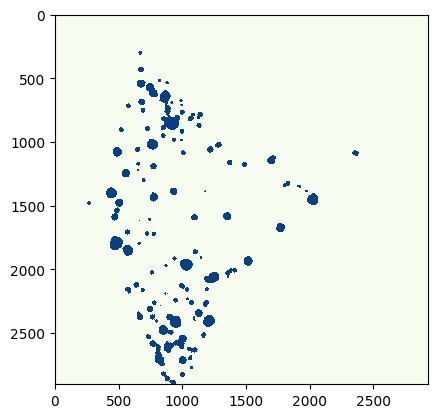

In [ ]:
clustering_cutoff = np.percentile(influence_map[influence_map > 0], 50)
binary_map = (influence_map > clustering_cutoff).astype(int)
plt.imshow(binary_map, cmap='GnBu', interpolation='nearest')

In [ ]:
from scipy.ndimage import label
import random

clusters, num_clusters = label(binary_map)

import matplotlib.colors as mcolors

num_colors = num_clusters + 1
colors = list(mcolors.CSS4_COLORS.values())
random.shuffle(colors)
random_cmap = mcolors.ListedColormap(colors[:num_colors])

plt.imshow(clusters, cmap=random_cmap, interpolation='nearest')
plt.savefig('clusters.png')

NameError: name 'binary_map' is not defined

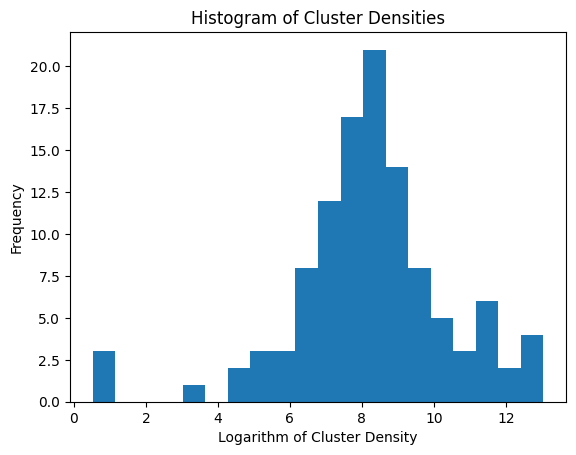

In [ ]:
cluster_densities = [influence_map[clusters == cluster_id].sum() for cluster_id in range(1, num_clusters + 1)]
plt.hist(np.log(cluster_densities), bins=20)
plt.xlabel("Logarithm of Cluster Density")
plt.ylabel("Frequency")
plt.title("Histogram of Cluster Densities")
plt.show()

In [ ]:
from scipy.spatial import ConvexHull

def add_clustered_noise(lat, lon, cluster_id, max_noise):
    # Extract hospital coordinates within the cluster
    cluster_coords = hospitals[hospitals['Cluster'] == cluster_id][['Latitude', 'Longitude']].values
    hull = ConvexHull(cluster_coords)
    centroid = cluster_coords.mean(axis=0)

    # Generate noisy coordinates centered around the centroid with Gaussian noise
    noisy_lat = np.random.normal(centroid[0], max_noise)
    noisy_lon = np.random.normal(centroid[1], max_noise)
    
    # Check if the new coordinates are within the convex hull; otherwise, limit the distance
    if hull.find_simplex([noisy_lat, noisy_lon]) < 0:
        direction = np.array([noisy_lat - centroid[0], noisy_lon - centroid[1]])
        direction /= np.linalg.norm(direction)
        noisy_lat, noisy_lon = centroid + direction * max_noise
    
    return noisy_lat, noisy_lon

# Apply this to each hospital in its respective cluster
hospitals['Anonymized Latitude'], hospitals['Anonymized Longitude'] = zip(*[
    add_clustered_noise(row['Latitude'], row['Longitude'], row['Cluster'], max_noise=row['Radius of Influence'])
    for _, row in hospitals.iterrows()
])


    

NameError: name 'hospitals' is not defined

In [ ]:
from scipy.spatial import ConvexHull